In [ ]:
import numpy as np
import pickle
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize

In [ ]:
import qumcmc 
from qumcmc.basic_utils import *
from qumcmc.energy_models import *

from qumcmc.classical_mcmc_routines import * 
# from qumcmc.quantum_mcmc_routines_qiskit import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 
from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc   #for qulacs backend (**faster)
from QuantumSamplingRoutines_s import *
from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics

import pickle, json 
import networkx as nx

In [ ]:
n_spins = 8
num_circuits = 147  ## number of pickle files

#### defs

In [ ]:
def build_energy_function_from_graph(graph: nx.Graph, name:str = 's'):
    
    nspins = graph.number_of_nodes()
    j = nx.get_edge_attributes(graph, 'J')
    J = np.zeros((nspins, nspins))

    for edge in graph.edges():
        J[edge[0], edge[1]] = j[edge]
        J[edge[1], edge[0]] = j[edge]

    H = np.array(list(nx.get_node_attributes(graph, 'h').values()))

    return IsingEnergyFunction(J =J, h=H, name= name)

In [ ]:
def new_proposal(counts: dict,twirl:int = 0,shots:int = 10**5):
    matrix_update = np.zeros((2**n_spins,2**n_spins))
    for state in counts:
        input,output = state.split(" ")
        matrix_update[int(input,2)^twirl,int(output,2)^twirl] = (counts[state]/shots) * 2**n_spins
    return matrix_update

def update_proposal(proposal_matrix, counts: dict,twirl:int = 0,shots:int = 10**5):
    new_matrix = new_proposal(counts,twirl,shots)
    return proposal_matrix + new_matrix

def normalize_proposal(proposal_matrix):
    col_sums = proposal_matrix.sum(axis=0)
    proposal_matrix_normed = proposal_matrix / col_sums[np.newaxis,:]
    return proposal_matrix_normed

In [ ]:
from qumcmc.energy_models import *
from qumcmc.prob_dist import *
from qumcmc.basic_utils import *


def build_matrix_from_dict(dict: dict):
    n = len(dict.keys())

    matrix = np.zeros((n,n), dtype= float)

    for k1 in dict.keys():
        for k2 in dict[k1].keys():

            matrix[int(k1, 2)][int(k2, 2)] = dict[k1][k2]

    return matrix
def build_dict_from_matrix(matrix:np.array, nspin:int):
    n = matrix.shape[0]

    dict = {}
    for k1 in range(n):
        
        z  = np.sum(matrix[k1])
        dict_tmp = {}
        for k2 in range(n):
            dict_tmp[int_to_str(k2, nspin)] = matrix[k1][k2] / z
        
        dict[int_to_str(k1, nspin)] = dict_tmp
    
    return dict

def build_mcmc_from_transition_dict(
    n_hops: int,
    model: IsingEnergyFunction,
    transition_dict: dict,
    initial_state: Optional[str] = None,
    temperature: float = 1.,
    verbose:bool= False,
    include_asymmetry:bool = False
):
    """
    ARGS:
    -----
    Nhops: Number of time you want to run mcmc
    num_spins: number of spins
    num_elems: 2**(num_spins)
    model:
    return_last_n_states: (int) Number of states in the end of the M.Chain you want to consider for prob distn (default value is last 500)
    return_both (default=False): If set to True, in addition to dict_count_return_lst_n_states, also returns 2 lists:
                                "list_after_transition: list of states s' obtained after transition step s->s' " and
                                "list_state_mchain_is_in: list of states markov chain was in".
    RETURNS:
    --------
    Last 'dict_count_return_last_n_states' elements of states so collected (default value=500). one can then deduce the distribution from it!
    
    """
    num_spins = model.num_spins

    if initial_state is None : 
        initial_state = MCMCState(get_random_state(num_spins), accepted=True)
    else:
        initial_state = MCMCState(initial_state, accepted=True)
    
    current_state: MCMCState = initial_state
    energy_s = model.get_energy(current_state.bitstring)
    if verbose : print("starting with: ", current_state.bitstring, "with energy:", energy_s)

    mcmc_chain = MCMCChain([current_state])


    for _ in tqdm(range(0, n_hops), desc= 'running MCMC steps ...', disable= not verbose):
        # get sprime
        t_dict = DiscreteProbabilityDistribution(transition_dict[current_state.bitstring])
        s_prime =  np.random.choice(list(t_dict.keys()), size= 1, 
                                  p = list(t_dict.values()))[0]
        
        # accept/reject s_prime
        energy_sprime = model.get_energy(s_prime)   # to make this scalable, I think you need to calculate energy ratios.
        
        delta_energy = energy_sprime - energy_s  # E(s')-E(s)
        exp_factor = np.exp(-delta_energy / temperature)
        
        if include_asymmetry :
            acceptance = min(
                1, exp_factor * (transition_dict[s_prime][current_state.bitstring]/ transition_dict[current_state.bitstring][s_prime])
            )  # for both QC case as well as uniform random strategy, the transition matrix Pij is symmetric!
            accepted = acceptance > np.random.rand()
        
        else :
            accepted = test_accept(
                energy_s, energy_sprime, temperature=temperature
            )
        
        
        mcmc_chain.add_state(MCMCState(s_prime, accepted))
        if accepted:
            current_state = mcmc_chain.current_state
            energy_s = model.get_energy(current_state.bitstring)
        
    return mcmc_chain


#### data analyses

In [ ]:
from os import listdir
proposal_matrix = np.zeros((2**n_spins,2**n_spins))

for file in [path for path in listdir("DATA/raw-circuit-outputs/") if path.endswith('pickle') and path.startswith("sm1id") ]:
    with open("DATA/raw-circuit-outputs/"+file, "rb") as fp:
        out = pickle.load(fp).get_counts()
        proposal_matrix = update_proposal(proposal_matrix,out)
           

In [ ]:
proposal_matrix = normalize_proposal(proposal_matrix)
sns.heatmap(proposal_matrix, norm = LogNorm(),cmap = sns.cm.rocket_r)

In [ ]:
sns.heatmap(proposal_matrix, cmap = sns.cm.rocket_r)

In [ ]:
transition_dict = build_dict_from_matrix(proposal_matrix, 8)

In [ ]:
with open('DATA/model-data/ising_exp.pkl', 'rb') as hl :
     trial_graph =  pickle.load(hl)

clrs = list(nx.get_node_attributes(trial_graph, 'h').values())
pos = nx.spring_layout(trial_graph)
nx.draw(trial_graph, pos, with_labels= True,)

nx.draw_networkx_edge_labels(trial_graph, pos, edge_labels= nx.get_edge_attributes(trial_graph, 'J'));
nc = nx.draw_networkx_nodes(trial_graph, pos, trial_graph.nodes(), node_size= 200, node_color= clrs,cmap=plt.cm.jet)

plt.colorbar(nc)
plt.axis('off')
plt.title("Interaction Map")
# plt.legend()
plt.show()



In [ ]:
clrs = list(nx.get_node_attributes(trial_graph, 'h').values())

In [ ]:
model = build_energy_function_from_graph(trial_graph, name= 'ising_exp')
model.model_summary(plot=True)


##### Low temp 1

In [ ]:
beta = 1.85; temperature = 1 / beta

esm_model = Exact_Sampling(model, beta= beta, verbose= True)
esm_model.sampling_summary()

In [ ]:
qchain_0 = build_mcmc_from_transition_dict(5000, esm_model, transition_dict, temperature= temperature, verbose= True, include_asymmetry=False)
cchain = classical_mcmc(5000, esm_model,temperature= temperature, verbose=True)
qchain_1 = quantum_enhanced_mcmc(5000, model, temperature= temperature, verbose= True)
qtrj_0 = get_trajectory_statistics(qchain_0, esm_model, verbose=False)
qtrj_1 = get_trajectory_statistics(qchain_1, esm_model, verbose=False)
ctrj = get_trajectory_statistics(cchain, esm_model, verbose=False)

In [ ]:
plt.figure(figsize=(10,10))

plt.hist(np.log10(qtrj_0['acceptance_prob']),label= 'quantum enhanced 0' , alpha= 0.4, bins= 20)

plt.hist(np.log10(qtrj_1['acceptance_prob']),label= 'quantum enhanced 1' , alpha= 0.8, bins= 20)

plt.hist(np.log10(ctrj['acceptance_prob']),label= 'classical uniform' ,alpha= 0.2, bins= 20)

# plt.xscale("log")

plt.xlabel("Acceptance Probabilities | scale: log10")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
# plt.plot(jsdiv_c, label= 'classical')
plt.plot(qtrj_0['kldiv'], label= 'quantum enhanced 0')
plt.plot(qtrj_1['kldiv'], label= 'quantum enhanced 1')
plt.plot(ctrj['kldiv'], label= 'classsical-uniform')


plt.xlabel("iterations ")
plt.ylabel("KL divergence")
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
magnetization_model = esm_model.get_observable_expectation(magnetization_of_state)
magnetization_c = calculate_runnning_magnetisation(cchain)
magnetization_q_0 = calculate_runnning_magnetisation(qchain_0)
magnetization_q_1 = calculate_runnning_magnetisation(qchain_1)

plt.figure(figsize=(10,8))
plt.plot(magnetization_c, label= 'classical')
plt.plot(magnetization_q_0, label= 'quantum_0')
plt.plot(magnetization_q_1, label= 'quantum_1')
plt.axhline(magnetization_model, label= 'original')
plt.xlabel("iterations")
plt.ylabel("magnetisation")
plt.legend()
plt.show()

##### low temp 2

Running Exact Sampling | beta :  2.85


running over all possible configurations: 100%|██████████| 256/256 [00:00<00:00, 18125.90it/s]

saving distribution to model ...
     MODEL : ising_exp |  beta : 2.85
Num Most Probable States : 6
Entropy : 2.8362513573467454
---------------------------------------------


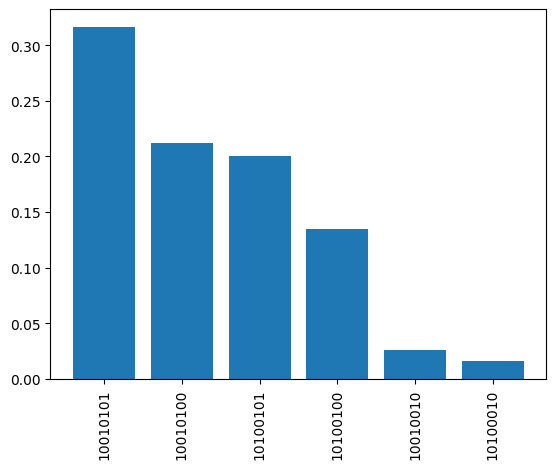

In [72]:
beta = 2.85; temperature = 1 / beta

esm_model = Exact_Sampling(model, beta= beta, verbose= True)
esm_model.sampling_summary()

In [73]:
qchain_0 = build_mcmc_from_transition_dict(5000, esm_model, transition_dict, temperature= temperature, verbose= True, include_asymmetry=False)
cchain = classical_mcmc(5000, esm_model,temperature= temperature, verbose=True)
qchain_1 = quantum_enhanced_mcmc(5000, model, temperature= temperature, verbose= True)
qtrj_0 = get_trajectory_statistics(qchain_0, esm_model, verbose=False)
qtrj_1 = get_trajectory_statistics(qchain_1, esm_model, verbose=False)
ctrj = get_trajectory_statistics(cchain, esm_model, verbose=False)

starting with:  00000010 with energy: -0.75


running MCMC steps ...: 100%|██████████| 5000/5000 [00:01<00:00, 3826.24it/s]


starting with:  00011000 with energy: 1.1900000000000002


running MCMC steps ...: 100%|██████████| 5000/5000 [00:00<00:00, 14930.47it/s]


starting with:  11010111 with energy: 1.61


runnning quantum MCMC steps . ..: 100%|██████████| 5000/5000 [00:11<00:00, 436.25it/s]


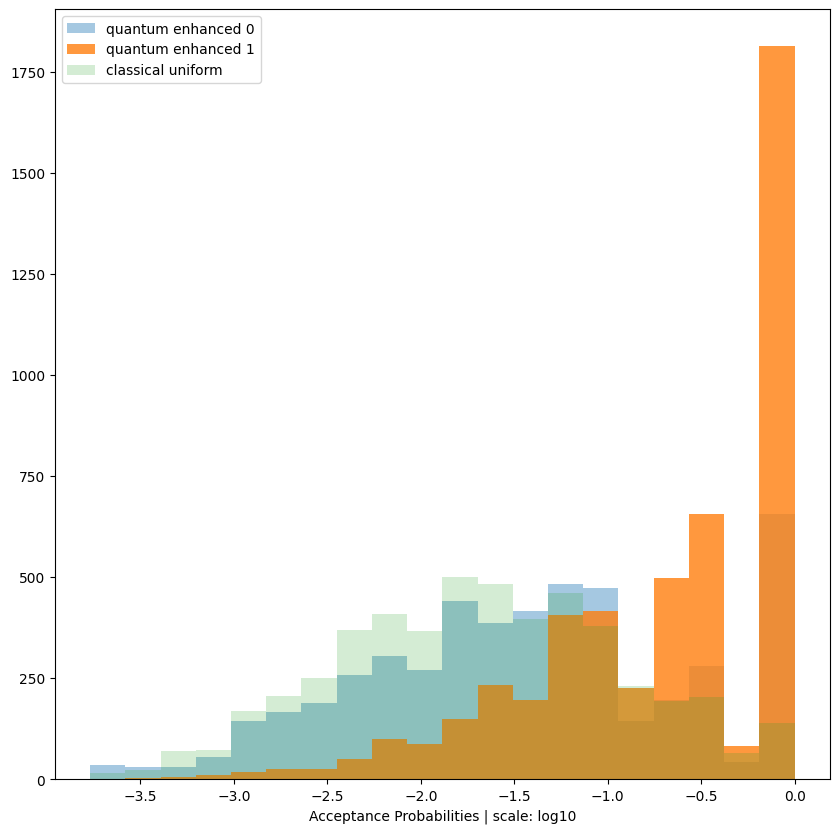

In [74]:
plt.figure(figsize=(10,10))

plt.hist(np.log10(qtrj_0['acceptance_prob']),label= 'quantum enhanced 0' , alpha= 0.4, bins= 20)

plt.hist(np.log10(qtrj_1['acceptance_prob']),label= 'quantum enhanced 1' , alpha= 0.8, bins= 20)

plt.hist(np.log10(ctrj['acceptance_prob']),label= 'classical uniform' ,alpha= 0.2, bins= 20)

# plt.xscale("log")

plt.xlabel("Acceptance Probabilities | scale: log10")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

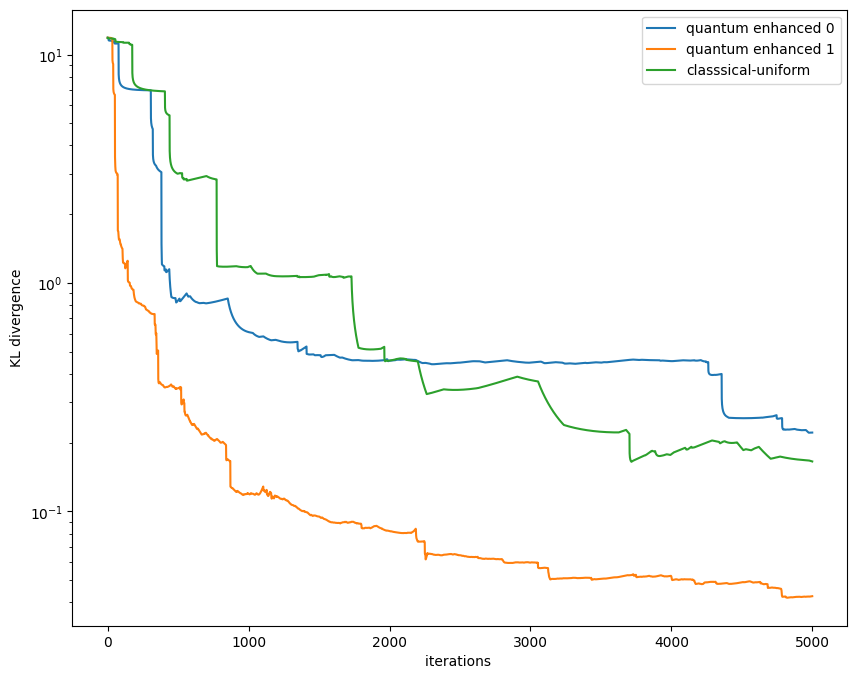

In [75]:
plt.figure(figsize=(10,8))
# plt.plot(jsdiv_c, label= 'classical')
plt.plot(qtrj_0['kldiv'], label= 'quantum enhanced 0')
plt.plot(qtrj_1['kldiv'], label= 'quantum enhanced 1')
plt.plot(ctrj['kldiv'], label= 'classsical-uniform')


plt.xlabel("iterations ")
plt.ylabel("KL divergence")
plt.yscale('log')
plt.legend()
plt.show()

100%|██████████| 5000/5000 [00:01<00:00, 3621.49it/s]


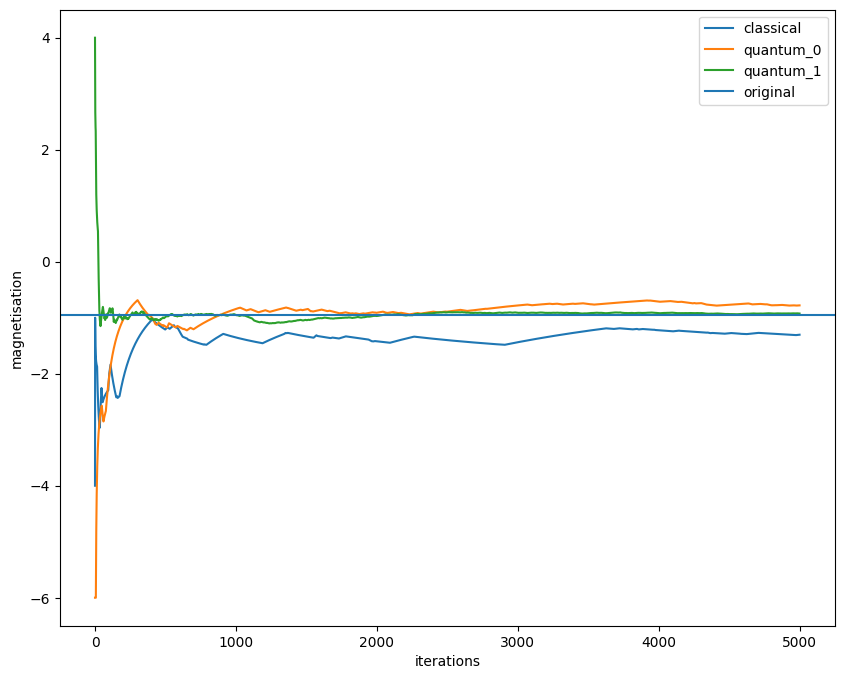

In [76]:
magnetization_model = esm_model.get_observable_expectation(magnetization_of_state)
magnetization_c = calculate_runnning_magnetisation(cchain)
magnetization_q_0 = calculate_runnning_magnetisation(qchain_0)
magnetization_q_1 = calculate_runnning_magnetisation(qchain_1)

plt.figure(figsize=(10,8))
plt.plot(magnetization_c, label= 'classical')
plt.plot(magnetization_q_0, label= 'quantum_0')
plt.plot(magnetization_q_1, label= 'quantum_1')
plt.axhline(magnetization_model, label= 'original')
plt.xlabel("iterations")
plt.ylabel("magnetisation")
plt.legend()
plt.show()

##### High temp

In [ ]:
model = build_energy_function_from_graph(trial_graph, name= 'ising_exp')
model.model_summary(plot=False)

beta = 0.75; temperature = 1 / beta

esm_model = Exact_Sampling(model, beta= beta, verbose= True)
esm_model.sampling_summary()

In [ ]:
qchain_0 = build_mcmc_from_transition_dict(5000, esm_model, transition_dict, temperature= temperature, verbose= True, include_asymmetry=False)
cchain = classical_mcmc(5000, esm_model,temperature= temperature, verbose=True)
qchain_1 = quantum_enhanced_mcmc(5000, model, temperature= temperature, verbose= True)
qtrj_0 = get_trajectory_statistics(qchain_0, esm_model, verbose=False)
qtrj_1 = get_trajectory_statistics(qchain_1, esm_model, verbose=False)
ctrj = get_trajectory_statistics(cchain, esm_model, verbose=False)

In [ ]:
plt.figure(figsize=(10,10))

plt.hist(np.log10(qtrj_0['acceptance_prob']),label= 'quantum enhanced 0' , alpha= 0.4, bins= 20)

plt.hist(np.log10(qtrj_1['acceptance_prob']),label= 'quantum enhanced 1' , alpha= 0.8, bins= 20)

plt.hist(np.log10(ctrj['acceptance_prob']),label= 'classical uniform' ,alpha= 0.2, bins= 20)

# plt.xscale("log")

plt.xlabel("Acceptance Probabilities | scale: log10")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
# plt.plot(jsdiv_c, label= 'classical')
plt.plot(qtrj_0['kldiv'], label= 'quantum enhanced 0')
plt.plot(qtrj_1['kldiv'], label= 'quantum enhanced 1')
plt.plot(ctrj['kldiv'], label= 'classsical-uniform')


plt.xlabel("iterations ")
plt.ylabel("KL divergence")
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
magnetization_model = esm_model.get_observable_expectation(magnetization_of_state)
magnetization_c = calculate_runnning_magnetisation(cchain)
magnetization_q_0 = calculate_runnning_magnetisation(qchain_0)
magnetization_q_1 = calculate_runnning_magnetisation(qchain_1)

plt.figure(figsize=(10,8))
plt.plot(magnetization_c, label= 'classical')
plt.plot(magnetization_q_0, label= 'quantum_0')
plt.plot(magnetization_q_1, label= 'quantum_1')
plt.axhline(magnetization_model, label= 'original')
plt.xlabel("iterations")
plt.ylabel("magnetisation")
plt.legend()
plt.show()